In [14]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.layers.convolutional import *
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [6]:
!python3 -m pip install opencv-python==4.6.0.66

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


[ WARN:0@571.662] global /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./data/data/garbage/glass/paper1.jpg'): can't open/read file: check file path/integrity


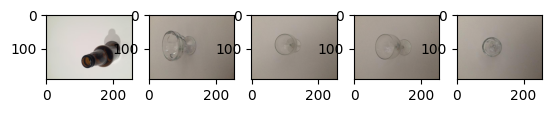

In [17]:
#data processing
def read_and_resize(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
        img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
        imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
        # convert to rgb
        img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    return img_result

def show_in_row(list_of_images, titles = None, disable_ticks = False):
    count = len(list_of_images)
    for idx in range(count):
        subplot = plt.subplot(1, count, idx+1)
        if titles is not None:
            subplot.set_title(titles[idx])

        img = list_of_images[idx]
        cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(img, cmap=cmap)
        if disable_ticks:
            plt.xticks([]), plt.yticks([])
    plt.show()

glass_path = "./data/data/garbage/glass/"
plastic_path = "./data/data/garbage/plastic/"
cardboard_path = "./data/data/garbage/cardboard/"
paper_path = "./data/data/garbage/paper/"

glassData = []

with open("data/one-indexed-files.txt") as f:
    try:
        for i in f.readlines():
            glassData.append(read_and_resize(glass_path+str(str(i.split()[0]))))
    except:
        pass


show_in_row(glassData[:5])

# Model 1

##  CNN (keras)


In [18]:
img = glassData[0]
imgShape = img.shape
imgShape

(192, 256, 3)

In [ ]:
from keras.optimizer_v1 import SGD, Adam

kernelSize = (3, 3)
model = Sequential()
model.add(Conv2D(32, kernelSize, input_shape=imgShape, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(64, kernelSize, padding='same', activation='relu'))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernelSize, padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.005, metrics=['accuracy']))